# Inspector tutorial

#### What is inspector ?  
   Vai_q_pytorch provides a function called inspector to help users diagnose neural network (NN) models under different device architectures. The inspector can predict target device assignments based on hardware constraints.The generated inspection report can be used to guide  users to modify or optimize the NN model, greatly reducing the difficulty and time of deployment. It is recommended to inspect float models before quantization.

In [1]:
import torch
import torch.nn as nn

In [2]:
# Import inspector API
# 
# Note:
# You can ignore warning message related with XIR. 
# The inspector relies on 'vai_utf' package. In conda env vitis-ai-pytorch in Vitis-AI docker, vai_utf is ready. But if vai_q_pytorch is installed by source code, it needs to install vai_utf in advance.
from pytorch_nndct import Inspector

Matplotlib is building the font cache; this may take a moment.
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'



[VAIQ_NOTE]: Loading NNDCT kernels...


In [3]:
from models.globals import DETECTORS, FILTERS, KERNEL_SIZE_CONVOLUTION, DILATION, STRIDE
from models.GregNet2D import GregNet2D
from models.GregNet2DModified import GregNet2DModified

In [17]:
import torch
from torch import nn


class CausalConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation):
        super(CausalConv2d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(self.padding, 0),
            dilation=(dilation, 1),
        )

    def forward(self, x):
        x = nn.functional.pad(x, (0, 0, self.padding, 0), mode="replicate")
        x = self.conv(x)
        return x


class ModuleWavenet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation):
        super(ModuleWavenet, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_dilated = CausalConv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            dilation=dilation,
        )
        self.batchnorm = nn.BatchNorm2d(out_channels)

        self.gate_tanh = nn.ReLU6()
        self.gate_sigmoid = nn.Hardsigmoid()

        self.conv1x1 = nn.Conv2d(
            in_channels=out_channels, out_channels=32, kernel_size=(1, 1)
        )

    def forward(self, x):
        x_old = x

        x_a = self.conv_dilated(x)
        x_b = self.conv_dilated(x)

        x_a = self.batchnorm(x_a)
        x_b = self.batchnorm(x_b)

        # pixel gate
        x_skip = self.gate_tanh(x_a) * self.gate_sigmoid(x_b)
        x_skip = self.conv1x1(x_skip)

        # skip-connection
        if self.in_channels != self.out_channels:
            x_res = x_skip
        else:
            if x_old.size(2) < x_skip.size(2):
                x_res = x_old + x_skip[:, :, : x_old.size(2), :]
            else:
                x_res = x_skip + x_old[:, :, : x_skip.size(2), :]

        return x_res, x_skip


class GWaveNet2DModified(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, stride):
        super().__init__()

        self.Mod0 = ModuleWavenet(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            dilation=dilation**0,
        )
        self.Mod1 = ModuleWavenet(
            in_channels=32,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            dilation=dilation**1,
        )
        self.Mod2 = ModuleWavenet(
            in_channels=32,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            dilation=dilation**2,
        )
        self.Mod3 = ModuleWavenet(
            in_channels=32,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            dilation=dilation**3,
        )
        self.Mod4 = ModuleWavenet(
            in_channels=32,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            dilation=dilation**4,
        )
        self.Mod5 = ModuleWavenet(
            in_channels=32,
            out_channels=32,
            kernel_size=kernel_size,
            stride=stride,
            dilation=dilation**5,
        )
        self.Mod6 = ModuleWavenet(
            in_channels=32,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            dilation=dilation**6,
        )

        self.conv_1x1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1, 1))

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(1302, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        # reshape input tensor to add dummy height dimension
        x = x.view(
            x.size(0),
            x.size(1),
            x.size(-1),
            1,
        )

        x, xs0 = self.Mod0(x)
        x, xs1 = self.Mod1(x)
        x, xs2 = self.Mod2(x)
        x, xs3 = self.Mod3(x)
        x, xs4 = self.Mod4(x)
        x, xs5 = self.Mod5(x)
        x, xs6 = self.Mod6(x)

        xs = xs6

        for i in [xs0, xs1, xs2, xs3, xs4, xs5]:
            if xs.size(2) < i.size(2):
                xs = xs + i[:, :, :xs.size(2), :]
            else:
                xs = i + xs[:, :, :i.size(2), :]

        xs = self.conv_1x1(xs)
        xs = self.relu(xs)

        xs = self.flatten(xs)
        xs = self.fc1(xs)
        xs = self.relu(xs)

        xs = self.fc2(xs)

        return xs

In [18]:
# Specify a target name or fingerprint you want to deploy on
target = "DPUCZDX8G_ISA1_B4096"
# Initialize inspector with target
inspector = Inspector(target)


[VAIQ_NOTE]: Inspector is on.


In [20]:
# Start to inspect the float model
# Note: visualization of inspection results relies on the dot engine.If you don't install dot successfully, set 'image_format = None' when inspecting.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DETECTORS = ["H1", "L1", "V1"]
FILTERS = 64
KERNEL_SIZE_CONVOLUTION = 16
DILATION = 2
STRIDE = 2

# model = ModifiedGWaveNet(detectors=DETECTORS, filters=FILTERS, kernel_size=KERNEL_SIZE_CONVOLUTION, dilation=DILATION, stride=STRIDE)
# model = GregNet2D(d="pc")
# model = GregNet2DModified(d="pc")
model = GWaveNet2DModified(in_channels=len(DETECTORS), out_channels=FILTERS, kernel_size=2, dilation=DILATION, stride=STRIDE)
# model = GWaveNet2D(in_channels=3, out_channels=64, kernel_size=16, dilation=2, stride=2)

dummy_input = torch.FloatTensor(1, len(DETECTORS), 155648).uniform_(-1, 1)

inspector.inspect(model, (dummy_input,), device=device, output_dir="inspect", image_format="png") 


[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing GWaveNet2DModified...

[VAIQ_WARN][QUANTIZER_TORCH_REPLACE_RELU6]: ReLU6 has been replaced by ReLU.

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model nndct_st_GWaveNet2DModified_ed is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 103/103 [00:00<00:00, 651.22


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(inspect/GWaveNet2DModified.py)



[VAIQ_WARN]: GWaveNet2DModified::3960 is not tensor.

[VAIQ_WARN]: GWaveNet2DModified::3965 is not tensor.

[VAIQ_WARN]: GWaveNet2DModified::3970 is not tensor.

[VAIQ_WARN]: GWaveNet2DModified::4565 is not tensor.

[VAIQ_WARN]: GWaveNet2DModified::4703 is not tensor.

[VAIQ_WARN]: GWaveNet2DModified::4741 is not tensor.

[VAIQ_WARN]: GWaveNet2DModified::4779 is not tensor.

[VAIQ_WARN]: GWaveNet2DModified::4817 is not tensor.

[VAIQ_WARN]: GWaveNet2DModified::4855 is not tensor.

[VAIQ_WARN]: GWaveNet2DModified::4893 is not tensor.

[VAIQ_WARN]: Pad(GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod0]/CausalConv2d[conv_dilated]/ret.15) can't be fused

[VAIQ_WARN]: Pad(GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod1]/CausalConv2d[conv_dilated]/ret.31) can't be fused

[VAIQ_WARN]: Pad(GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod2]/CausalConv2d[conv_dilated]/ret.51) can't be fused

[VAIQ_WARN]: Pad(GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod3]/Ca


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:GWaveNet2DModified::GWaveNet2DModified/Conv2d[conv_1x1]/ret.235, op type:nndct_conv2d, output shape: [1, 1302, 1, 1]
node name:GWaveNet2DModified::GWaveNet2DModified/ReLU[relu]/ret.237, op type:nndct_relu, output shape: [1, 1302, 1, 1]



[VAIQ_NOTE]: Find subgraph for pad_fix_0:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod1]/CausalConv2d[conv_dilated]/ret.31, op type:nndct_pad_nd, output shape: [1, 77827, 1, 32]



[VAIQ_NOTE]: Find subgraph for pad_fix_0:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod4]/CausalConv2d[conv_dilated]/ret.95, op type:nndct_pad_nd, output shape: [1, 9755, 1, 32]



[VAIQ_NOTE]: Find subgraph for pad_fix_0:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod4]/CausalConv2d[conv_dilated]/ret.91, op type:nndct_pad_nd, output shape: [1, 9755, 1, 32]



[VAIQ_NOTE]: Find subgraph for pad_fix_0:
node name:GWaveNet2DModified::GWaveNet2DModified/Modu

I20240623 13:05:49.152856   127 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240623 13:05:49.152880   127 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240623 13:05:49.152887   127 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240623 13:05:49.152958   127 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_hsigmoid_vwA9jgBIDCt30rFa, with op num: 7
I20240623 13:05:49.152966   127 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240623 13:05:49.154857   127 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 2, DPU subgraph number 0
I20240623 13:05:49.154887   127 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240623 13:05:49.159368   127 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240623 13:05:49.159390   127 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240623 13:05:49.159395   127 co


[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:GWaveNet2DModified::GWaveNet2DModified/Flatten[flatten]/ret.239, op type:nndct_reshape, output shape: [1, 1302]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod4]/Conv2d[conv1x1]/ret.109, op type:nndct_conv2d, output shape: [1, 4886, 1, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:GWaveNet2DModified::GWaveNet2DModified/Linear[fc2]/ret, op type:nndct_dense, output shape: [1, 1]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod6]/CausalConv2d[conv_dilated]/Conv2d[conv]/ret.145, op type:nndct_conv2d, output shape: [1, 1302, 1, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod6]/Conv2d[conv1x1]/ret.161, op type:nndct_conv2d, output shape: [1, 1302, 1, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
nod

I20240623 13:05:49.356740   127 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240623 13:05:49.356760   127 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240623 13:05:49.356765   127 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240623 13:05:49.356827   127 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_permute_xho8dPqm301E6eHA, with op num: 2
I20240623 13:05:49.356832   127 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
W20240623 13:05:49.357923   127 PartitionPass.cpp:4160] [UNILOG][WARNING] xir::Op{name = GWaveNet2DModified__GWaveNet2DModified_ret_9_swim_transpose_1, type = transpose} has been assigned to CPU.
I20240623 13:05:49.357977   127 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 2, DPU subgraph number 0
I20240623 13:05:49.357996   127 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240623 13:05:49.361801   127 compile_p


[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod5]/Conv2d[conv1x1]/ret.129, op type:nndct_conv2d, output shape: [1, 2475, 1, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod6]/ret.159, op type:nndct_elemwise_mul, output shape: [1, 1302, 1, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod2]/ret.67, op type:nndct_elemwise_mul, output shape: [1, 19462, 1, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod4]/ret.107, op type:nndct_elemwise_mul, output shape: [1, 4886, 1, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod0]/ret.27, op type:nndct_elemwise_mul, output shape: [1, 77825, 1, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
n

I20240623 13:05:49.561666   127 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240623 13:05:49.561691   127 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240623 13:05:49.561698   127 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240623 13:05:49.561764   127 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_STldzrmUoK4guhkM, with op num: 4
I20240623 13:05:49.561770   127 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240623 13:05:49.563656   127 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 2, DPU subgraph number 0
I20240623 13:05:49.563728   127 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240623 13:05:49.569314   127 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240623 13:05:49.569348   127 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240623 13:05:49.569360   127 compile_pass_mana


[VAIQ_NOTE]: Find subgraph for depthwise_fix_25:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod1]/ret.47, op type:nndct_elemwise_mul, output shape: [1, 38915, 1, 64]



[VAIQ_NOTE]: Find subgraph for depthwise_fix_25:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod5]/ret.127, op type:nndct_elemwise_mul, output shape: [1, 2475, 1, 32]



[VAIQ_NOTE]: Find subgraph for depthwise_fix_25:
node name:GWaveNet2DModified::GWaveNet2DModified/ModuleWavenet[Mod3]/ret.87, op type:nndct_elemwise_mul, output shape: [1, 9739, 1, 64]



[VAIQ_NOTE]: The operators assigned to the CPU are as follows(see more details in 'inspect/inspect_DPUCZDX8G_ISA1_B4096.txt'):
node name                                                                                                   op Type              hardware constraints
----------------------------------------------------------------------------------------------------------  -------------------  ---------------------------

I20240623 13:05:49.770318   127 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240623 13:05:49.770342   127 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240623 13:05:49.770349   127 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240623 13:05:49.770430   127 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_elemwise_mul_jIUWN5Eqet2oOc7J, with op num: 3
I20240623 13:05:49.770463   127 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240623 13:05:49.772827   127 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 0
I20240623 13:05:49.772862   127 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240623 13:05:49.777910   127 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240623 13:05:49.777931   127 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240623 13:05:49.777937   127 compile_pas


[VAIQ_NOTE]: Dot image is generated.(inspect/inspect_DPUCZDX8G_ISA1_B4096.png)

[VAIQ_NOTE]: =>Finish inspecting.


##### Inspection result anaysis:
1. In this toy model, there are two operations will be assigned to cpu. The reasons for being allocated to the CPU are shown in the column of hardware constraints.
2. The target device of an input node is determined by its consumer.
3. Here, we found that a special permute operation("ToyModel::ToyModel/AdaptiveAvgPool2d[adaptive_avg_pool2d]/146_sink_transpose_0") is inserted by quantizer. Due to data layout difference between Pytorch('NCHW') and XIR('NHWC'), if quantizer inserts some permutes(which the node message in inspect file will inform us about), these permutes may prevent the entire model from being deployed to the target device. Sometimes, we can cancel out this automatically inserted permute by inserting a permute in the original float model, sometimes, we can't.
4. If you want more details about the inspection, see the inspection report under the output directory you specified.
5. The dot image can help you to analyze inspection result in a more intuitive way. "svg" and "png" format are both supported.


In [14]:
# Show the dot image
from IPython.display import Image
Image('inspect/inspect_DPUCZDX8G_ISA1_B4096.png')

2. Modify the original model according to the hardware constrains message and try to cancel out the permute inserted by quantizer with by inserting a permute in the original float model(more details see hints in inspect_{target}.txt)

In [7]:
# Modified the ToyModel
class ModifiedToyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='nearest')  # set mode = "nearest"
        self.conv = torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu = torch.nn.ReLU()
        self.adaptive_avg_pool2d = torch.nn.AdaptiveAvgPool2d(output_size=1)
        
    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.adaptive_avg_pool2d(x)
        x = x.permute(0, 2, 3, 1) # insert a permute to cancel out the permute inserted by quantizer.
        x = x.reshape(x.size(0), -1)
        return x


In [8]:
# Inspect the modified model
model = ModifiedToyModel()
inspector.inspect(model, (dummy_input,), device=device, output_dir="inspect", image_format="png") 


[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing ModifiedToyModel...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 9/9 [00:00<00:00, 1182.01it/s, OpInfo: name = return_0, type = Return]                                                                


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(inspect/ModifiedToyModel.py)

[VAIQ_NOTE]: All the operators are assigned to the DPU(see more details in 'inspect/inspect_DPUCAHX8L_ISA0_SP.txt')

[VAIQ_NOTE]: Dot image is generated.(inspect/inspect_DPUCAHX8L_ISA0_SP.png)

[VAIQ_NOTE]: =>Finish inspecting.


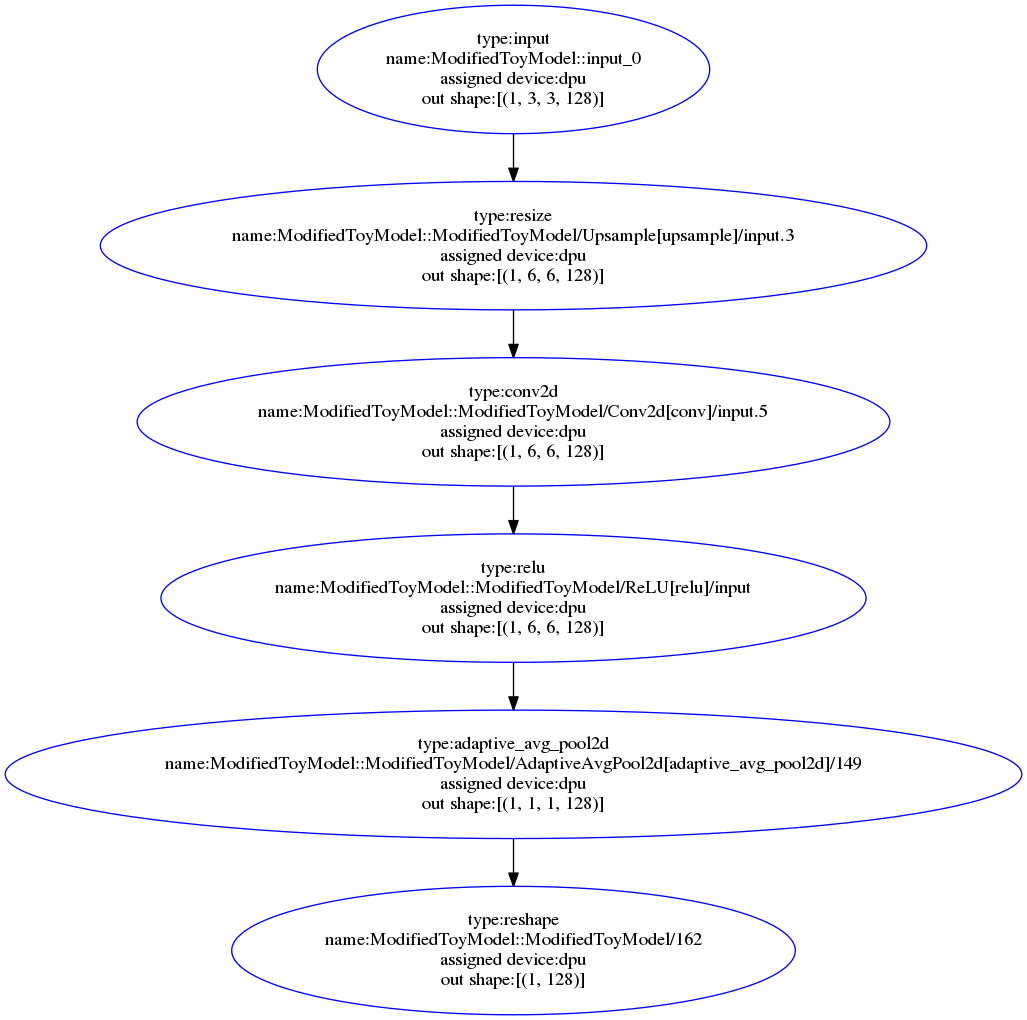

In [9]:
# Show the dot image
from IPython.display import Image
Image('inspect/inspect_DPUCAHX8L_ISA0_SP.png')

##### Inspection result anaysis:
Finally, under the guidance of the inspector, the entire ToyModel can be deployed on the DPU.